In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from lyft_dataset_sdk.lyftdataset import LyftDataset
import matplotlib.pyplot as plt
from prepare_lyft_data import parse_train_csv,get_pc_in_image_fov,level5data,parse_string_to_box

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

Error occured when importing object classification models


In [3]:
import pickle

In [4]:
pred_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/train_val_pred.csv"

In [5]:
import pandas as pd
val_df=pd.read_csv(pred_file,index_col="Id")

In [6]:
val_df.head()

,PredictionString
Id,
a7987dbcf6606e357c9df7d7bd2bdd43a780a4968bccab62d2cbfb708fe8d607,0.9751747250556946 2437.807138331297 802.76536...
73db47c47ac2605e6b81347fffca8e08ef203e38e27460e04d6bd562ce7ebb10,0.976259708404541 2479.2424422848444 818.74728...
37db0f88c828e2184ee6df05be5d4186a724c33de18fd96a0ec10ec1004bbc38,0.9885321855545044 2459.058054859333 828.03135...
aabfd17c84bfdc95b7c24f123c3d736d339fd9ab98605316abf3ace3fbc74aa7,0.9882034659385681 2459.0835189753966 828.0258...
1b0af29fe866e9d70a2dfc4dfaad2ff14e8884fc21360d974d9a0a7cf1a7efbb,0.9943069815635681 2453.178326720454 822.21979...


In [7]:
data_idx=1
sample_token=val_df.index[data_idx]
boxes_str=val_df.loc[sample_token,'PredictionString']

In [8]:
boxes=parse_string_to_box(boxes_str)

In [9]:
sample_record=level5data.get("sample",sample_token)

In [10]:
from skimage.io import imread

In [11]:
from prepare_lyft_data import transform_box_from_world_to_sensor_coordinates,get_train_data_sample_token_and_box

In [12]:
lidar_top_token=sample_record['data']['LIDAR_TOP']
lidar_path=level5data.get_sample_data_path(lidar_top_token)

In [13]:
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [29]:
lpc=LidarPointCloud.from_file(lidar_path)

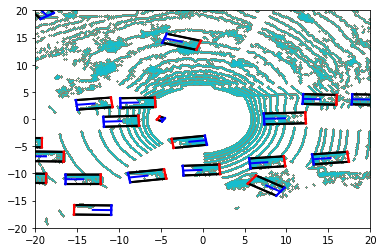

In [30]:
fig,ax=plt.subplots()
for pred_box in boxes:
    box_in_lidar_coord=transform_box_from_world_to_sensor_coordinates(pred_box,lidar_top_token,level5data)

    pts=lpc.points
    ax.scatter(pts[0,:],pts[1,:],s=0.1)
    ax.set_xlim([-50,50])
    ax.set_ylim([-20,20])
    view_mtx=np.eye(2)
    box_in_lidar_coord.render(ax,view=view_mtx)

In [19]:
camera_token=sample_record['data']['CAM_FRONT']

In [20]:
camera_image_path,_,cam_intrinsic=level5data.get_sample_data(camera_token)

[2472.45488014  822.33836488  -18.46810488]
[2436.29454236  841.23719074  -18.44157974]
[2469.6272996   812.23125422  -18.43759633]


(1024, 0)

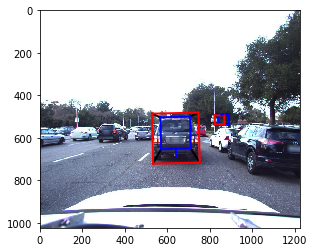

In [45]:
image_array=imread(camera_image_path)
fig,ax=plt.subplots()
ax.imshow(image_array)
for pred_box in boxes:
    if pred_box.score>0.9 and pred_box.center[2]>-18.5:
        box_in_camera_coord=transform_box_from_world_to_sensor_coordinates(pred_box,camera_token,level5data)
        box_in_camera_coord.render(ax,view=cam_intrinsic,normalize=True)
        print(pred_box.center)
        

ax.set_xlim([0,image_array.shape[1]])
ax.set_ylim([image_array.shape[0],0])

## Show ground truth data

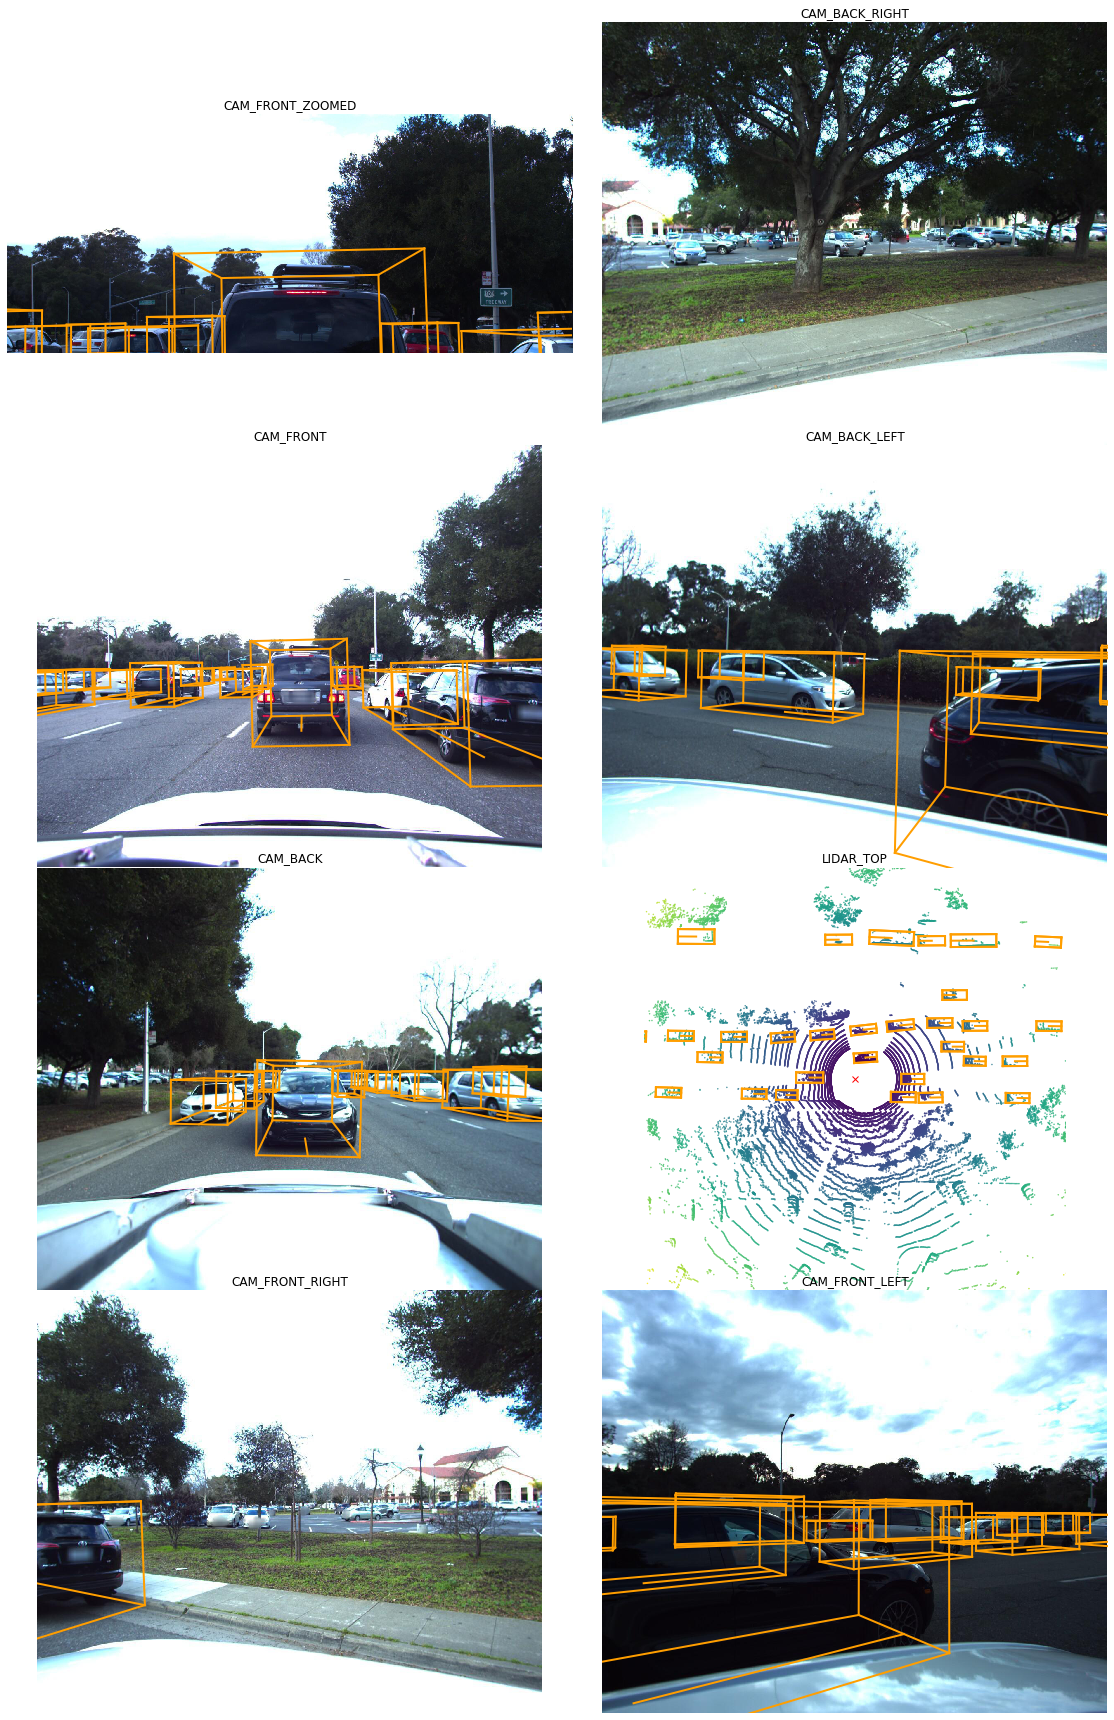

In [19]:
level5data.render_sample(sample_token=sample_token)

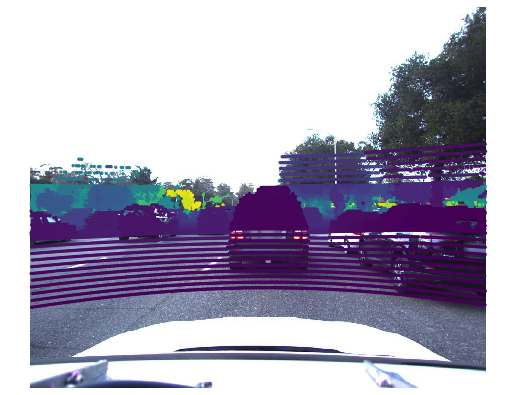

In [20]:
level5data.render_pointcloud_in_image(sample_token)

In [21]:
pred_obj.iloc[15,:]

NameError: name 'pred_obj' is not defined

In [ ]:
pred_obj.iloc[14,:]

In [ ]:
pred_obj.iloc[17,:]

In [ ]:
from object_classifier import TLClassifier
from vis_util import draw_bounding_boxes_on_image_array,draw_bounding_box_on_image_array

In [ ]:
tlc=TLClassifier()

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=False)
det_box

In [ ]:
image_to_draw=np.copy(image_array)
det_box=det_box[:,0:4]
draw_bounding_boxes_on_image_array(image_to_draw,det_box)
plt.imshow(image_to_draw)

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=True)
mask, pc_3d, pc_2d, lpc, img=get_pc_in_image_fov(lidar_top_token,'CAM_FRONT',level5testdata,bounding_box=det_box[1,0:4])

In [ ]:
pc_2d.shape

In [ ]:
fig,ax=plt.subplots()
ax.imshow(img)
ax.scatter(pc_2d[0,:],pc_2d[1,:])

In [ ]:
image_array.shape